# Write a metric for the detection of TDEs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('baseline2018a.db')
# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots


## write a class to get required data for test function run() inside metric

In [4]:
class getDataMetric(metrics.BaseMetric):
    """
    returns required data 
    """
    
    def __init__(self, colname=['airmass', 'expMJD'], **kwargs):
        self.colname = colname
        
        super().__init__(col=colname, metricDtype='object', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # return dataSlice directly
        
        result = dataSlice
        
        return result

In [115]:
metric = getDataMetric(colname=['night', 'observationStartMJD', 
                                'fiveSigmaDepth', 'filter'])
#slicer = slicers.UniSlicer()
#slicer = slicers.HealpixSlicer(nside=16)
ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<730' # first two year
#sqlconstraint = 'observationStartMJD<60553'
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)


Querying database SummaryAllProps with constraint night<730 for columns ['fiveSigmaDepth', 'fieldDec', 'fieldRA', 'night', 'filter', 'observationStartMJD']
Found 452269 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<730" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [116]:
dataSlice = Sky.metricValues.data[0]
dataSlice.dtype

dtype((numpy.record, [('fiveSigmaDepth', '<f8'), ('fieldDec', '<f8'), ('fieldRA', '<f8'), ('night', '<i8'), ('filter', '<U256'), ('observationStartMJD', '<f8')]))

In [117]:
dataSlice['observationStartMJD'].shape

(4587,)

In [89]:
np.unique(dataSlice['filter'])

array(['g', 'i', 'r', 'u', 'y', 'z'],
      dtype='<U256')

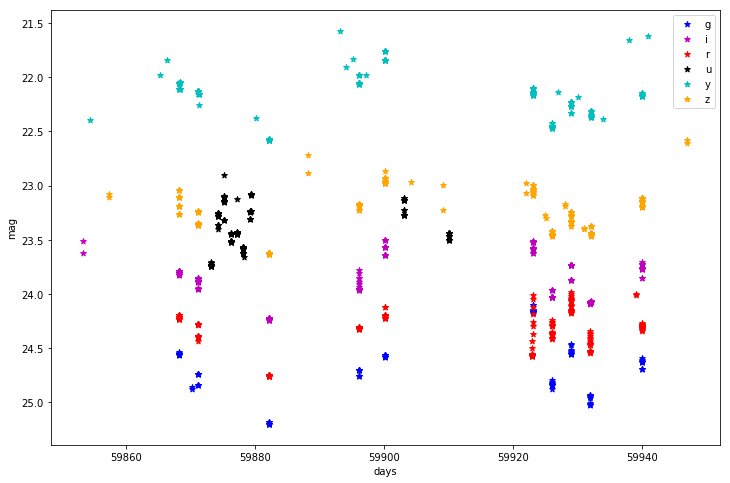

In [32]:

def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter'):
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}

    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]

        plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

plotlc(dataSlice, time_key='observationStartMJD', 
       mag_key='fiveSigmaDepth', filter_key='filter')


## Test functions inside class

#### make light curve from txt file

In [71]:
def read_lightCurve(asciifile='TDEfaintfast_z0.1.dat'):
        
    lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
    
    return lcv_template


def make_lightCurve(time, filters):
    
    #datafile
    asciifile = 'TDEfaintfast_z0.1.dat'
    
    lcv_template = read_lightCurve(asciifile)
    transDuration = lcv_template['ph'].max() - lcv_template['ph'].min()
    
    lcMags = np.zeros(time.size, dtype=float)
    
    for f in set(lcv_template['flt']):
        fMatch_ascii = np.where(np.array(lcv_template['flt']) == f)[0]
        
        # Interpolate the lightcurve template to the times of the observations, in this filter.
        lc_ascii_filter = np.interp(time, np.array(lcv_template['ph'], float)[fMatch_ascii],
                                        np.array(lcv_template['mag'], float)[fMatch_ascii])
        lcMags[filters == f.decode("utf-8")] = lc_ascii_filter[filters == f.decode("utf-8")]
    
    return lcMags



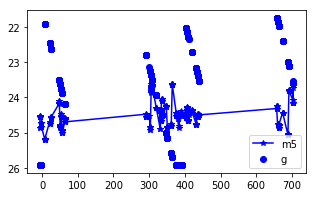

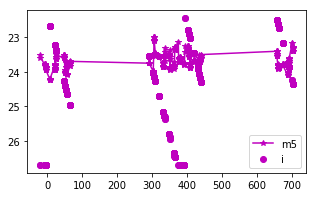

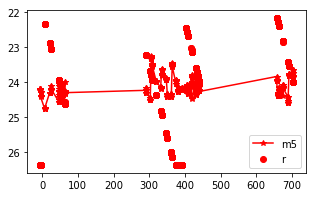

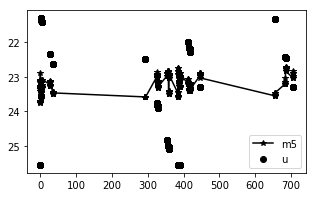

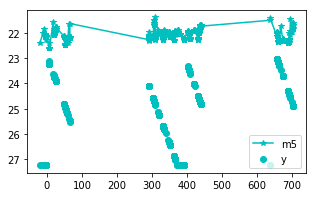

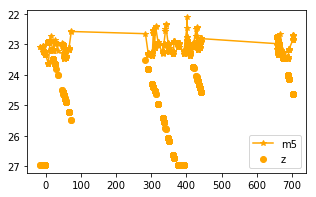

In [125]:
dataSlice.sort(order='observationStartMJD')
lcv_template = read_lightCurve(asciifile)
transDuration = lcv_template['ph'].max() - lcv_template['ph'].min() # in days

time = (dataSlice['observationStartMJD'] - dataSlice['observationStartMJD'].min() - 22)
lcEpoch = (dataSlice['observationStartMJD'] - dataSlice['observationStartMJD'].min() - 22) % transDuration
filters = dataSlice['filter']
lcMags = make_lightCurve(lcEpoch, filters)

colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}

for f in np.unique(filters):
    
    plt.figure(figsize=(5, 3))
    plt.scatter(time[np.where(filters==f)], lcMags[np.where(filters==f)], color=colors[f], label=f)
    
    plt.plot(time[np.where(filters==f)], dataSlice['fiveSigmaDepth'][np.where(filters==f)], color=colors[f], marker='*', label='m5')
    plt.legend()
    plt.ylim(plt.ylim()[::-1])

In [70]:
lcMags.shape

(1184,)

#### sketch function run() inside metric

In [331]:
# columns needed, change to self.varname when add into class
asciifile = 'TDEfaintfast_z0.1.dat'
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'

# light curve parameters
tshift = -22
peakEpoch = 0
nearPeakT = 5

# condition parameters, add to __init__()
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
nTotal = 1 # total number of observation
   
# sort dataSlice in order of time
dataSlice.sort(order=mjdCol)
tSpan = (dataSlice[mjdCol].max() - dataSlice[mjdCol].min()) # in days
    
lcv_template = read_lightCurve(asciifile)
transDuration = lcv_template['ph'].max() - lcv_template['ph'].min() # in days

# get the epoch of each light curve by np.fmod
lcEpoch = np.fmod(dataSlice[mjdCol] - dataSlice[mjdCol].min(), transDuration) + tshift

# total number of transients possibly detected
nTransMax = np.ceil(tSpan/transDuration)

# generate the actual light curve
lcMags = make_lightCurve(lcEpoch, filters)
lcSNR = utils.m52snr(lcMags, dataSlice[m5Col])
lcFilters = dataSlice[filterCol]

# Identify detections above SNR for each filter
lcAboveThresh = np.zeros(len(lcSNR), dtype=bool)
for f in np.unique(lcFilters):
    filtermatch = np.where(dataSlice[filterCol] == f)
    lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= detectSNR[f], True, False)
    

lcNumber = np.floor((dataSlice[mjdCol] - dataSlice[mjdCol].min()) / transDuration)
ulcNumber = np.unique(lcNumber)

# check conditions for each light curve
lcDetect = np.ones(len(ulcNumber), dtype=bool)
for i, lcN in enumerate(ulcNumber):

    lcN_idx = np.where(lcNumber == lcN)
    
    
    lcEpoch_i = lcEpoch[lcN_idx]
    lcMags_i = lcMags[lcN_idx]
    lcFilters_i = lcFilters[lcN_idx]
    lcAboveThresh_i = lcAboveThresh[lcN_idx]
    
    
    #------  add conditions below --------------
    # total number of observations
    nObsTotal = len(lcAboveThresh_i == True)
    
    # pre peak 
    
    # near Peak  
    nearPeak = (lcEpoch_i >= peakEpoch - nearPeakT/2) & (lcEpoch_i <= peakEpoch + nearPeakT/2) 
    nearPeakIdx = np.where(nearPeak==True)
    
    # number of observations near peak
    nObsNearPeak =  len (lcAboveThresh_i[nearPeakIdx] == True)
        


# return values   
nDetected = len(np.where(lcDetect == True))
    


In [273]:
np.fmod(-22, 130)

-22

In [186]:
from functools import reduce
idx = reduce(np.intersect1d, (np.where(lcAboveThresh==True), np.where(lcNumber==2), np.where(lcFilters=='r')) )




In [308]:
df_tde = pd.DataFrame()

df_tde['time'] = dataSlice['observationStartMJD'] - dataSlice['observationStartMJD'].min()
df_tde['lcEpoch'] = lcEpoch
df_tde['lcMags'] = lcMags
df_tde['filter'] = lcFilters
df_tde['lcSNR'] = lcSNR
df_tde['lcAboveThresh'] = lcAboveThresh

df_tde['lcNumber'] = lcNumber
df_tde.to_csv('df_tde.csv')
df_tde.iloc[200:300]

,time,lcEpoch,lcMags,filter,lcSNR,lcAboveThresh,lcNumber
200,17.908657,-4.091343,23.237910,y,1.845644,False,0.0
201,17.909074,-4.090926,23.237854,y,1.846534,False,0.0
202,17.924155,-4.075845,23.235797,y,2.024280,False,0.0
203,19.903044,-2.096956,21.324379,u,46.268163,True,0.0
204,19.903461,-2.096539,21.324357,u,46.286615,True,0.0
205,19.903877,-2.096123,21.324334,u,46.305076,True,0.0
206,19.904294,-2.095706,21.324311,u,46.323548,True,0.0
207,19.904711,-2.095289,21.324289,u,46.342031,True,0.0
208,19.905127,-2.094873,21.324266,u,46.360523,True,0.0
209,19.905544,-2.094456,21.324243,u,46.379026,True,0.0


In [119]:
nTransMax

6.0

#### import the Class 

In [ ]:
# combine all above functions into TDEsMetricTest class

class TDEsMetricTest(BaseMetric):
    """Based on the transientMetric, but uses an ascii input file and provides option to write out lightcurve.
    
    Calculate what fraction of the transients would be detected. Best paired with a spatial slicer.
    The lightcurve in input is an ascii file per photometric band so that different lightcurve
    shapes can be implemented.

    Parameters
    ----------
    asciifile : str
        The ascii file containing the inputs for the lightcurve (per filter):
        File should contain three columns - ['ph', 'mag', 'flt'] -
        of phase/epoch (in days), magnitude (in a particular filter), and filter.
    
    detectSNR : dict, optional
        An observation will be counted toward the discovery criteria if the light curve SNR
        is higher than detectSNR (specified per bandpass).
        Values must be provided for each filter which should be considered in the lightcurve.
        Default is {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
    

    dataout : bool, optional
        If True, metric returns full lightcurve at each point. Note that this will potentially
        create a very large metric output data file.
        If False, metric returns the number of transients detected.
    """
    def __init__(self, asciifile, metricName='TDEsMetricTest', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 tshift=0, peakEpoch=0, nearPeakT=5, 
                 nObsNearPeak={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 dataout=False, **kwargs):
        
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.dataout = dataout

        # condition parameters
        self.detectSNR = detectSNR
        self.tshift = tshift
        self.peakEpoch = peakEpoch
        self.nearPeakT = nearPeakT

        self.nObsNearPeak = nObsNearPeak

        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(TDEsMetricTest, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        else:
            super(TDEsMetricTest, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', metricName=metricName,
                                                       **kwargs)
        self.read_lightCurve(asciifile)
    
        print('Finish initializing metric')

    def read_lightCurve(self, asciifile):
        
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))

        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
    

    def make_lightCurve(self, time, filters):
                
        lcv_template = self.lcv_template
        
        lcMags = np.zeros(time.size, dtype=float)
        
        for f in set(lcv_template['flt']):
            fMatch_ascii = np.where(np.array(lcv_template['flt']) == f)[0]
            
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            lc_ascii_filter = np.interp(time, np.array(lcv_template['ph'], float)[fMatch_ascii],
                                            np.array(lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == f.decode("utf-8")] = lc_ascii_filter[filters == f.decode("utf-8")]
        
        return lcMags

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the detectability of a transient with the specified lightcurve.

        If self.dataout is True, then returns the full lightcurve for each object instead of the total
        number of transients that are detected.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float or dict
            The total number of transients that could be detected. (if dataout is False)
            A dictionary with arrays of 'lcNumber', 'lcMag', 'detected', 'time', 'detectThresh', 'filter'
        """

        # Sort the entire dataSlice in order of time.  
        dataSlice.sort(order=self.mjdCol)
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) # in days
        
        lcv_template = self.lcv_template
        transDuration = lcv_template['ph'].max() - lcv_template['ph'].min() # in days

        lcEpoch = np.fmod(dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min(), transDuration) + self.tshift

        # total number of transients possibly detected
        nTransMax = np.ceil(tSpan/transDuration)

        # generate the actual light curve
        lcFilters = dataSlice[self.filterCol]
        lcMags = self.make_lightCurve(lcEpoch, lcFilters)
        lcSNR = utils.m52snr(lcMags, dataSlice[self.m5Col])

        # Identify detections above SNR for each filter
        lcAboveThresh = np.zeros(len(lcSNR), dtype=bool)
        for f in np.unique(lcFilters):
            filtermatch = np.where(dataSlice[self.filterCol] == f)
            lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f], True, False)
            

        lcNumber = np.floor((dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min()) / transDuration)
        ulcNumber = np.unique(lcNumber)

        # check conditions for each light curve
        lcDetect = np.ones(len(ulcNumber), dtype=bool)
        for i, lcN in enumerate(ulcNumber):

            lcN_idx = np.where(lcNumber == lcN)
            
            lcEpoch_i = lcEpoch[lcN_idx]
            lcMags_i = lcMags[lcN_idx]
            lcFilters_i = lcFilters[lcN_idx]
            lcAboveThresh_i = lcAboveThresh[lcN_idx]
            
            # total number of observations
            nObsTotal = len(lcAboveThresh_i == True)
            
            # prePeakCheck 
            prePeakCheck = (lcEpoch_i < self.peakEpoch)


            # number of observations before peak



            # near Peak 
            nearPeakCheck = (lcEpoch_i >= self.peakEpoch - self.nearPeakT/2) & (lcEpoch_i <= self.peakEpoch + self.nearPeakT/2) 
            nearPeakIdx = np.where(nearPeakCheck==True)
            
            # number of observations near peak
            nObsNearPeakTotal =  len (lcAboveThresh_i[nearPeakIdx] == True)
                
            # check number of observations near peak for each band
            for f in np.unique(lcFilters_i):
                nearPeakIdx_f = np.intersect1d( nearPeakIdx, np.where(lcFilters_i==f) )

                if len(lcAboveThresh_i[nearPeakIdx_f]) <= self.nObsNearPeak[f]:

                    lcDetect[i] = False

            # number of filters near band
            lcFilters_i[nearPeakIdx]


        # return values   
        nDetected = len(np.where(lcDetect == True)[0])

        print(nTransMax, nDetected, lcDetect)

        return float(nDetected / nTransMax) if nTransMax!=0 else 0


In [4]:
# import from source file
from mycode.TDEsMetricTest import TDEsMetricTest


finish init
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<700 for columns ['filter', 'fieldRA', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec']
Found 431650 visits
Running:  ['transmetricSky']
6.0 5 [ True  True  True  True  True]
6.0 2 [ True  True]
4.0 1 [False  True False]
4.0 1 [ True False False]
4.0 1 [False  True False]
4.0 1 [False  True False]
4.0 2 [False  True  True False]
6.0 3 [False  True  True False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
4.0 0 [False False False]
4.0 0 [False False False]
4.0 1 [False  True False]
4.0 1 [False  True False]
4.0 1 [False False  True]
4.0 1 [False  True False]
4.0 0 [False False False]
4.0 2 [False  True  True False]
4.0 2 [False  True  True False]
6.0 2 [False  True False False  True]
6.0 3 [False  True  True False  True]
6.0 1 [False False False  True]
6.0 0 [False False False False]
6.0 1 [ True False False False]
6.

6.0 2 [False  True False False  True]
6.0 0 [False False False False False]
6.0 2 [False False  True False  True]
6.0 1 [False False  True False False]
6.0 1 [False False  True False False]
6.0 2 [False False  True False  True]
6.0 2 [False False  True  True False]
6.0 2 [False False  True  True False]
6.0 2 [False False  True  True False]
5.0 3 [False  True False  True  True]
6.0 0 [False False False False]
5.0 0 [False False False False]
6.0 0 [False False False False]
4.0 0 [False False False]
4.0 0 [False False False]
4.0 1 [False  True False]
4.0 0 [False False False]
4.0 0 [False False False False]
4.0 1 [False False  True False]
4.0 2 [False  True  True False]
4.0 1 [False False  True False]
4.0 0 [False False False False]
4.0 1 [False False  True False]
4.0 0 [False False False]
4.0 0 [False False False False]
4.0 1 [False  True False]
4.0 1 [False  True False False]
4.0 1 [False  True False False]
4.0 0 [False False False]
4.0 2 [False  True  True False]
4.0 2 [False  True  Tr

5.0 2 [False  True False False  True]
5.0 1 [False False False False  True]
5.0 2 [False  True False False  True]
5.0 2 [False False  True False  True]
5.0 1 [False False  True False False]
5.0 1 [False False False False  True]
5.0 1 [False False False False  True]
5.0 1 [False False False False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False  True  True False False]
5.0 2 [False  True  True False False]
4.0 1 [False  True False False]
4.0 0 [False False False False]
6.0 2 [ True False False  True False False]
4.0 1 [False False  True False]
4.0 2 [False  True  True False]
6.0 2 [ True False False  True False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 0 [False False False False

6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 0 [False False False False]
6.0 0 [False False False False]
6.0 0 [False False False False]
6.0 0 [False False False False]
6.0 1 [False False False  True]
6.0 0 [False False False False]
6.0 0 [False False False False]
6.0 0 [False False False False]
6.0 1 [False False False  True]
6.0 2 [False  True False  True]
6.0 2 [False  True False False  True]
6.0 2 [False False  True False  True]
4.0 1 [False False  True False]
4.0 0 [False False False False]
4.0 0 [False False False False]
4.0 0 [False False False False]
4.0 1 [False False  True False]
4.0 1 [False False  True False]
5.0 2 [False False  True False  True]
4.0 0 [False False False False]
4.0 0 [False False False False]
4.

5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
4.0 1 [False False  True False]
5.0 2 [False  True False False  True]
5.0 2 [False  True False False  True]
5.0 2 [False  True False False  True]
5.0 2 [False  True False False  True]
5.0 0 [False False False False False]
5.0 1 [False False False False  True]
5.0 1 [False False False False  True]
4.0 0 [False False False False]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False  True]
5.0 2 [False  True False False  True]
5.0 1 [False  True False False False]
4.0 2 [ True  True False False]
4.0 3 [ True  True  True False]
4.0 2 [False  True  True False]
6.0 4 [ True False  True  True False  True]
6.0 2 [ True False False  True False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False

6.0 1 [False  True False False False False]
6.0 2 [ True  True False False False False]
6.0 2 [False  True False False  True False]
6.0 2 [False  True False False  True False]
6.0 2 [False  True False False  True False]
6.0 2 [False  True False False  True False]
6.0 1 [False False False  True False]
6.0 2 [False False False  True  True]
6.0 1 [False False False  True False]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 2 [False False  True False  True]
6.0 2 [False False  True False  True]
6.0 3 [False  True False False  True  True]
5.0 1 [False False False False  True]
4.0 0 [False False False False]
4.0 0 [False False False False]
4.0 2 [False  True  True False]
4.0 1 [False False  True False]
5.0 3 [False  True  True False  True]
5.0 1 [False False  True False False]
4.0 1 [False False  True False]
5.0 2 [False False  True False  True]
5.0 2 [False False  True False

6.0 1 [ True False False False False]
6.0 0 [False False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 2 [ True  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 2 [False  True False False  True False]
6.0 2 [False  True False False  True False]
6.0 2 [False  True False False  True False]
6.0 3 [False  True False False  True  True]
6.0 1 [False False False  True False]
6.0 1 [False False False  True False]
6.0 0 [False False False False]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False  True]
6.0 1 [False False False False  True]
6.0 1 [False False False False  True]
6.0 2 [False False  True False  True]
5.

6.0 3 [ True False False  True False  True]
6.0 3 [ True False False  True False  True]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 1 [ True False False False False]
6.0 0 [False False False False False]
6.0 1 [False  True False False False]
6.0 1 [False  True False False False False]
6.0 2 [False  True False  True False False]
6.0 3 [ True  True False  True False False]
6.0 2 [ True  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False  True False False False False]
6.0 1 [False False False  True False]
6.0 1 [False False False  True False]
6.0 1 [False False False  True]
6.0 0 [False False False False]
6.0 1 [False False False  True]
6.0 1 [False False False False  True]
6.0 1 [False False False False  True]
6.0 1 [False False False  True]
4.0 1 [False False  True False]
5.0 2 [False  True False False  True]
5.0 2 [False False  True False  True]
4.0 0 [False False False]


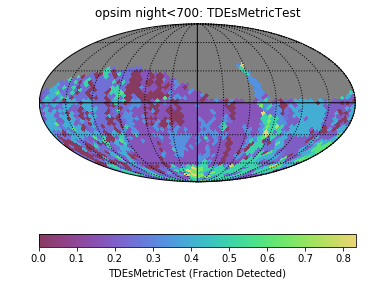

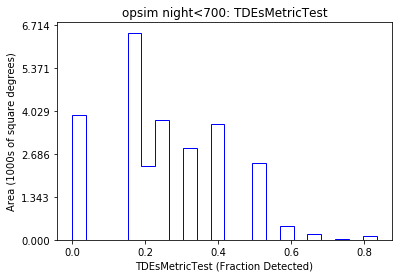

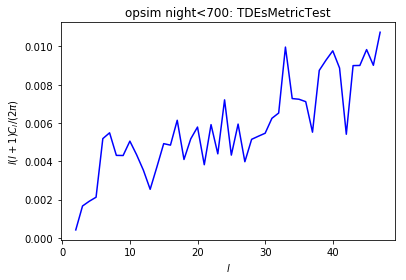

In [6]:
# run the metric
asciifile = 'TDEfaintfast_z0.1.dat'
transmetric = TDEsMetricTest(asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 tshift=0, peakEpoch=0, nearPeakT=5, 
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 5, 'i': 0, 'z': 0, 'y': 0},
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<700'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky},opsdb,outDir=outDir,resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)